In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx #To generate G(n,p) adj matrix

import math
import random
import sys

In [2]:
##A small utility
import time                                                

def timeit(method):

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print '%r (%r, %r) %2.2f sec' % \
              (method.__name__, args, kw, te-ts)
        return result

    return timed


In [3]:

class HamiltonianWorker(object):
    '''Class in charge of managing states and
    efficient energy calculation.
    
    Note: colors' index starts at 1. Vertex indices
    start at 0. (see broadcasting)
    '''
    
    def __init__(self, q=None, n=None, c=None,AdjM=np.array([])):
        if AdjM.size>0:
            adj_matrix = pd.DataFrame(AdjM)
        else:
            adj_matrix = self.__AdjMx_From_Gnp(n,float(c)/n)
        ##Initial Coloring
        self.q=q
        self.X = pd.Series(np.random.randint(low=1,high=q+1,size=adj_matrix.shape[0]))
        #COLORED adj_matrix e.g. A[i,j] = color of j. A[j,i]=color or i
        self.A = adj_matrix.multiply(self.X,axis=1)
        self.n = self.A.shape[0]
        # Get initial energy. Hamiltonian energy function.
        self.SumIdx = self.A.apply(lambda col:col==self.X).sum(axis=1) #Store count of bad edges indexed by vertex
        self.E = int(self.SumIdx.sum())
        if self.E%2 != 0:
            sys.exit('E from colored adj_matrix should be even')
            
        self.E = self.E/2.0
        # No vertex should have index 0. This is 'null' state and energy.
        self.X_new = np.zeros(self.A.shape[0])
        self.E_new = -1
        
        
    def walk(self,T, T_Period):
        '''
        Walks T_period steps the Markov Chain for a fixed temperature parameter.
        @param T: temperature
        @param T_Period: number of steps. This is the epoch for each temperature update.
        @return Energy: last Energy found.
        @return X: last coloring found.
        @return dsc_ratio: descent ratio. e.g. nb of times dE<=0
        @return stct_dsc_ratio: strict descent ratio. e.g. nb of times dE<0
        '''
        assert T>=0.0, 'Temperature parameter must be positive, use bootstrap() method in case of no initial guess.'
        if T==0.0:
            raise ValueError('T has hit 0.0, use bootstrap() method in case of no initial guess.')
        descents, strict_descents = 0,0
        for k in range(T_Period):
            newColor, newEnergy = self.__next_state_and_energy()
            dE = newEnergy - self.E
            if dE > 0.0 and math.exp(-dE/T) >= random.random():
                self.__update(newColor, newEnergy)
            elif dE<=0:
                descents += 1
                if dE < 0.0 :
                    strict_descents +=1
                self.__update(newColor,newEnergy)
                
        return (self.E, float(descents)/T_Period, float(strict_descents)/T_Period)
    
    
    def bootstrap(self):
        '''Call in case no T parameter is guessed '''
        T,steps = 0.0,0
        prevEnergy = self.E
        while T==0.0:
            steps+=1
            newColor,newEnergy = self.__next_state_and_energy()
            self.__update(newColor,newEnergy)
            T = abs(self.E - prevEnergy)
            prevEnergy = self.E
        return T,steps
       
        
    def __AdjMx_From_Gnp(self,n,p):
        
        G_np=nx.fast_gnp_random_graph(n,p) #Undirected graph by default
        adj_matrix = nx.adjacency_matrix(G_np)
        adj_matrix = adj_matrix.toarray()

        if not (adj_matrix.transpose() == adj_matrix).all():
            sys.exit('Non-symmetric adjacency matrix')
        if np.any(adj_matrix.diagonal()):
            sys.exit('No self loops allowed.')
    
        return pd.DataFrame(adj_matrix)
    
    
    def __update(self,X_new, E_new): 
        '''update when sampling is accepted'''
        if ((E_new != self.E_new) or (not (X_new==self.X_new).all())):
            sys.exit('New state and energy should have been generated by Hamiltonian on previous step.')
            
        #Re-Color Matrix
        new_color = X_new.iloc[self.u_idx]
        self.A.iloc[:,self.u_idx][self.A.iloc[:,self.u_idx]!=0] = new_color
        self.X = X_new
        self.E = E_new
        
        self.X_new = np.zeros(self.n)
        self.E_new = -1
        self.u_idx = -1
        
          
    def __next_state_and_energy(self):
        '''calculate next state and its energy
        Both are sent at the same time for efficiency'''
            
        self.u_idx = np.random.randint(self.n)
        next_X = self.X.copy(deep=True)
        next_X.iloc[self.u_idx] = np.random.choice(np.delete(np.arange(1,self.q+1),next_X.iloc[self.u_idx]-1)) 
        self.X_new = next_X
        self.E_new = self.__new_energy()
        return (self.X_new, self.E_new)
        
    def __new_energy(self):
        '''Calculation is done with respect to candidate update.
        Otherwise, hamiltonian energy function can be costly to
        calculate from scratch for large graphs'''
        old_sum = self.E
        sum_old = (self.A.iloc[self.u_idx,:] == self.X.iloc[self.u_idx]).sum()
        sum_update = (self.A.iloc[self.u_idx,:] == self.X_new.iloc[self.u_idx]).sum()
        delta = (sum_update - sum_old)
        return old_sum + delta
    
    def get_E_from_scratch(self):
        return self.A.apply(lambda col:col==self.X).sum(axis=1).sum()/2.0    


In [4]:


class BlackSmith(object):
    
    '''The One who does annealing'''
    def __init__(self,schedule=None,q=2,n=None,desc_thresh=0.98,T_Period=10,workline=None,AdjM=np.array([])):
        self.q=q
        self.n=n
        self.desc_thresh = desc_thresh
        self.T_Period = T_Period
        self.workline = workline
        self.eps = np.finfo(float).eps
        self.AdjMatrix = AdjM
        if schedule not in ['Cauchy','Baseline','Exp']:
            sys.exit('Unknown temperature schedule')
        self.schedule = schedule
        self.X=None
        self.E=None
        
    def work(self):
        'Print annealing schedule started...'
        
        for mean_deg,temperature in self.workline:
            E,X,trace = self.__anneal(c=mean_deg,temp=temperature)
            yield (mean_deg,temperature,E,X,trace)
        
    @timeit
    def __anneal(self,c=5,temp=None):
        '''One annealing run corresponds to one Graph G(n,c/n)'''
        steps = 0
        T = temp
        coloring_trace = []
        worker = HamiltonianWorker(q=self.q,n=self.n,c=c,AdjM=self.AdjMatrix)
        
        if not temp:
            T,dsteps = worker.bootstrap()
            steps +=dsteps
            
        if self.schedule == 'Exp':
            try:
                E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                steps += self.T_Period
                coloring_trace.append(E)
            except:
                print 'Could not finish annealing run. T hit 0.0'
                return coloring_trace
            
            print 'Desc ratio %.2f'%desc_ratio
            
            while  self.eps < (self.desc_thresh - desc_ratio):
                T = T * 1.5
                
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
                
            print 'Desc ratio %.2f'%desc_ratio 
                
            while T > self.eps :
                T = T*0.95
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
            print 'Temperature after cooling %.2f'%T
            
            #Check if we get a valid coloring
            assert(int(worker.get_E_from_scratch())==int(E)), \
                "Final energy must be equal to energy of returned coloring E=%.2f, Ecol=%.2f"%(int(E),int(worker.get_E_from_scratch()))
            assert (worker.X.values<=self.q).all(), \
                "Max color value must be %d"%(self.q)
            assert (worker.X.values>=1).all(), \
                "Min color value must be %d"%(1)
        
            print 'E=%d'%E
            print 'Ec=%d'%int(worker.get_E_from_scratch())
            self.E=E
            self.X=worker.X.values
            self.X.shape = (self.X.size,1)
            return (self.E,self.X,coloring_trace)
        
        elif self.schedule == 'Baseline':
            
            try:
                E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                steps += self.T_Period
                coloring_trace.append(E)
            except:
                print 'Could not finish annealing run. T hit 0.0'
                return coloring_trace
            
            print 'Desc ratio %.2f'%desc_ratio
                
            while T > self.eps :
                T = T*0.95
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
            print 'Temperature after cooling %.2f'%T
            
            #Check if we get a valid coloring
            assert(int(worker.get_E_from_scratch())==int(E)), \
                "Final energy must be equal to energy of returned coloring E=%.2f, Ecol=%.2f"%(int(E),int(worker.get_E_from_scratch()))
            assert (worker.X.values<=self.q).all(), \
                "Max color value must be %d"%(self.q)
            assert (worker.X.values>=1).all(), \
                "Min color value must be %d"%(1)
        
            print 'E=%d'%E
            print 'Ec=%d'%int(worker.get_E_from_scratch())
            self.E=E
            self.X=worker.X.values
            self.X.shape = (self.X.size,1)
            return (self.E,self.X,coloring_trace)
            
        elif self.schedule == 'Cauchy' :
            try:
                E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                steps += self.T_Period
                coloring_trace.append(E)
            except:
                print 'Could not finish annealing run. T hit 0.0'
                return coloring_trace
            
            print 'Desc ratio %.2f'%desc_ratio
            
            while  self.eps < (self.desc_thresh - desc_ratio):
                T = T * 1.5
                
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
                
            print 'Desc ratio %.2f'%desc_ratio 
            
            while (desc_ratio - self.desc_thresh) > self.eps :
                T = T/1.5
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace 
                
            print 'Desc ratio %.2f'%desc_ratio
            
            
            while  self.eps < (self.desc_thresh - desc_ratio):
                T = T * 1.5
                
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
            print 'Desc ratio %.2f'%desc_ratio 
            
            
            print 'Active temperature: %.2f'%T
                
            while T > self.eps :
                T = T/1.5
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
            print 'Temperature after cooling %.2f'%T
            
            #Check if we get a valid coloring
            assert(int(worker.get_E_from_scratch())==int(E)), \
                "Final energy must be equal to energy of returned coloring E=%.2f, Ecol=%.2f"%(int(E),int(worker.get_E_from_scratch()))
            assert (worker.X.values<=self.q).all(), \
                "Max color value must be %d"%(self.q)
            assert (worker.X.values>=1).all(), \
                "Min color value must be %d"%(1)
        
            print 'E=%d'%E
            print 'Ec=%d'%int(worker.get_E_from_scratch())
            self.E=E
            self.X=worker.X.values
            self.X.shape = (self.X.size,1)
            return (self.E,self.X,coloring_trace)
        

Desc ratio 0.80
Desc ratio 0.80
Temperature after cooling 0.00
E=0
Ec=0
'__anneal' ((<__main__.BlackSmith object at 0x000000000C2C4240>,), {'c': 10, 'temp': 30}) 35.38 sec
Desc ratio 0.65
Desc ratio 0.80
Temperature after cooling 0.00
E=0
Ec=0
'__anneal' ((<__main__.BlackSmith object at 0x000000000C2C4240>,), {'c': 25, 'temp': 40}) 26.74 sec
Desc ratio 0.70
Desc ratio 0.85
Temperature after cooling 0.00
E=4
Ec=4
'__anneal' ((<__main__.BlackSmith object at 0x000000000C2C4240>,), {'c': 50, 'temp': 50}) 34.49 sec


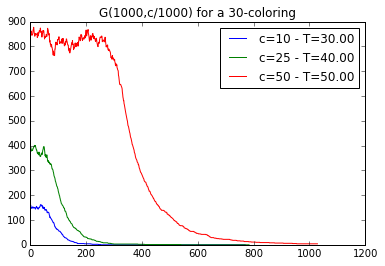

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools

## Example execution
nb_vertices = 1000
mean_degs = [10,25,50] #mean degress for Gnp's
nb_colors = 30
CoolingPeriod = 20 #TODO: optimize, try different parameters.This parameter is really the unit for the x axis in the plot below
T_guess = [30,40,50] #This parameter is very sensitive, if increase can augment running time a lot, but also tends to make the initial jump shorter

#itertools.repeat(T_guess,len(mean_degs)
ct_pairs = zip(mean_degs,T_guess)
bsm = BlackSmith(q=nb_colors,n=nb_vertices,T_Period=CoolingPeriod,workline=ct_pairs,desc_thresh=0.8,schedule='Exp')

for c,T,E,X,trace in bsm.work():
    plt.plot(trace,label='c=%d - T=%.2f'%(c,T))
plt.legend(loc='best')
plt.title('G(%d,c/%d) for a %d-coloring'%(nb_vertices,nb_vertices,nb_colors))
#plt.savefig("E_ByC.jpeg",format='jpeg')

Desc ratio 0.70
Desc ratio 0.90
Temperature after cooling 0.00
E=0
Ec=0
'__anneal' ((<__main__.BlackSmith object at 0x000000001F049278>,), {'c': 2, 'temp': 10.0}) 10.98 sec
Desc ratio 0.60
Desc ratio 0.80
Temperature after cooling 0.00
E=3
Ec=3
'__anneal' ((<__main__.BlackSmith object at 0x000000001F049278>,), {'c': 4, 'temp': 10.0}) 10.03 sec
Desc ratio 0.60
Desc ratio 0.80
Temperature after cooling 0.00
E=8
Ec=8
'__anneal' ((<__main__.BlackSmith object at 0x000000001F049278>,), {'c': 6, 'temp': 10.0}) 7.78 sec
Desc ratio 0.40
Desc ratio 0.80
Temperature after cooling 0.00
E=27
Ec=27
'__anneal' ((<__main__.BlackSmith object at 0x000000001F049278>,), {'c': 8, 'temp': 10.0}) 7.70 sec
Desc ratio 0.70
Desc ratio 0.80
Temperature after cooling 0.00
E=41
Ec=41
'__anneal' ((<__main__.BlackSmith object at 0x000000001F049278>,), {'c': 10, 'temp': 10.0}) 8.02 sec
Desc ratio 0.60
Desc ratio 0.80
Temperature after cooling 0.00
E=67
Ec=67
'__anneal' ((<__main__.BlackSmith object at 0x000000001F049

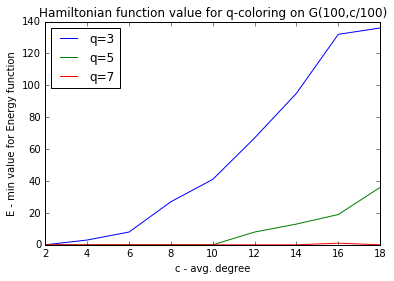

In [19]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools

nb_vertices = 100
mean_degs = range(2,20,2)
colors = [3,5,7]
CoolingPeriod = 10
T_guess = 10.0
ct_pairs = zip(mean_degs,itertools.repeat(T_guess,len(mean_degs)))

for chr_nbr in colors:             
    bsm = BlackSmith(q=chr_nbr,n=nb_vertices,
                     T_Period=CoolingPeriod,workline=ct_pairs,desc_thresh=0.8,schedule='Exp')
    avg_deg, f_energy = zip(*[(c,trace[-1]) for c,T,E,X,trace in bsm.work()])
    plt.plot(avg_deg, f_energy,label="q=%d"%chr_nbr)
               
plt.legend(loc='best')
plt.xlabel('c - avg. degree')
plt.ylabel('E - min value for Energy function')
plt.title('Hamiltonian function value for q-coloring on G(%d,c/%d)'%(nb_vertices,nb_vertices))
#plt.savefig("MinVal_ByQ.jpeg",format='jpeg')

In [6]:
## Run this first to keep all solutions
XEs=[]

Desc ratio 0.40
Desc ratio 0.90
Temperature after cooling 0.00
E=3
Ec=3
'__anneal' ((<__main__.BlackSmith object at 0x000000000BDC8240>,), {'c': None, 'temp': 2.0}) 7.71 sec
Desc ratio 0.50
Desc ratio 1.00
Temperature after cooling 0.00
E=5
Ec=5
'__anneal' ((<__main__.BlackSmith object at 0x000000000BDC8240>,), {'c': None, 'temp': 3.0}) 8.62 sec
Desc ratio 0.80
Desc ratio 0.90
Temperature after cooling 0.00
E=6
Ec=6
'__anneal' ((<__main__.BlackSmith object at 0x000000000BDC8240>,), {'c': None, 'temp': 4.0}) 8.60 sec


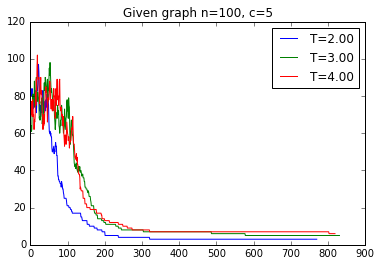

In [14]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.io import loadmat,savemat

nb_colors = 3
T_guess= [2.0,3.0,4.0]
cooling_period = 10
work_schedule = zip([None]*len(T_guess),T_guess)
given_AdjM = loadmat("graph_adjacency_matrix.mat")['A']

#c=5.0 but it is not necessary when Adj_matrix is given
bsm = BlackSmith(q=nb_colors,T_Period=cooling_period,workline=work_schedule,desc_thresh=0.85,schedule='Exp',AdjM=given_AdjM)


for c,T,E,X,trace in bsm.work():
    XEs.append((X,E))
    plt.plot(trace,label='T=%.2f'%(T))

plt.legend(loc='best')
plt.title('Given graph n=100, c=5')

In [10]:
best_X = sorted(XEs,key=lambda p:p[1])
X,E = best_X[0]
savemat("Castellon_Liu_result.mat",mdict={'X':X,'E':E})

In [11]:
## Brute force to get best possible sol
nb_iter = 50
bestE = E
bestX = None
for _ in range(nb_iter):
    bsm = BlackSmith(q=nb_colors,T_Period=cooling_period,workline=work_schedule,desc_thresh=0.8,schedule='Exp',AdjM=given_AdjM)
    for c,T,E,X,trace in bsm.work():
        if bestE>E:
            bestE=E
            bestX=X
            savemat("Castellon_Liu_result1.mat",mdict={'X':bestX,'E':bestE})
print "Best E found %d"%d

Desc ratio 0.60
Desc ratio 0.80
Temperature after cooling 0.00
E=4
Ec=4
'__anneal' ((<__main__.BlackSmith object at 0x000000000C1B2C50>,), {'c': None, 'temp': 2.0}) 7.67 sec
Desc ratio 0.60
Desc ratio 0.80
Temperature after cooling 0.00
E=6
Ec=6
'__anneal' ((<__main__.BlackSmith object at 0x000000000C1B2C50>,), {'c': None, 'temp': 3.0}) 7.43 sec
Desc ratio 0.40
Desc ratio 0.90
Temperature after cooling 0.00
E=5
Ec=5
'__anneal' ((<__main__.BlackSmith object at 0x000000000C1B2C50>,), {'c': None, 'temp': 4.0}) 7.95 sec
Desc ratio 0.60
Desc ratio 0.80
Temperature after cooling 0.00
E=4
Ec=4
'__anneal' ((<__main__.BlackSmith object at 0x000000000C2B0CF8>,), {'c': None, 'temp': 2.0}) 8.28 sec
Desc ratio 0.60
Desc ratio 0.90
Temperature after cooling 0.00
E=5
Ec=5
'__anneal' ((<__main__.BlackSmith object at 0x000000000C2B0CF8>,), {'c': None, 'temp': 3.0}) 7.10 sec
Desc ratio 0.60
Desc ratio 0.80
Temperature after cooling 0.00
E=4
Ec=4
'__anneal' ((<__main__.BlackSmith object at 0x000000000C2B

ValueError: too many values to unpack

## Interpretation:
- the initial straight line is because our initial gues of T(T_guess) and random point chosen to start  most likely takes us to a region with local minimum only. A high initial T encourages exploration but it also makes overall convergence slower.
- What the algorithm does is go to that local minimum and when it sees that there is a reasonable rate of 'metropolis' steps that we can take opposite to the descent direction then we do it (until it reaches the 'descent regime' again). That is (part of) the spike above.
- 'descent regime' is defined by desc_ratio parameter.
- Once we hit EXACTLY one desc_ratio we just descend until we get 0 stric improvement
- Precision of global optimum depends mostly on CoolingPeriod parameter. This, however, can hurt performance. 
- when L_T and U_T are the same at the end. No strict descent elimination was necessary.(To check)
- Observation: larger mean degree graph requires larger initial temperature.
- colorings close to the mean degree are more interesting and challenging that high nb colorings

## Note for competition:
- Parameters that matter (in order), performance depends on tunning of these: T_guess, desc_thresh, cooling_period.